Written by AI22BTECH11023, SHAP by AI22BTECH11005

In [2]:
# All imports
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from robustbench.model_zoo.cifar10 import linf as cifar10_linf_models
from robustbench.utils import load_model
from robustbench.data import load_cifar10
from torch.utils.data import TensorDataset, DataLoader
from torchattacks import PGD
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10
from captum.attr import Saliency


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Loading the CIFAR-10 dataset
# CIFAR-10 normalization statistics
mean_list = [0.4914, 0.4822, 0.4465]
std_list  = [0.2470, 0.2435, 0.2616]
mean = torch.tensor(mean_list, device=device).view(1,3,1,1)
std  = torch.tensor(std_list, device=device).view(1,3,1,1)
# Test data loader
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_list, std_list)
])
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2
)

Files already downloaded and verified


In [5]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load a high-accuracy pretrained ResNet-56 on CIFAR-10
model = torch.hub.load(
    'chenyaofo/pytorch-cifar-models',
    'cifar10_resnet56',
    pretrained=True
).to(device)
model.eval()

criterion = nn.CrossEntropyLoss()

Using cache found in /Users/sakethchakka/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


In [6]:
# 3) Pick one that exists—e.g. 'Carmon2019Unlabeled'
print("Available CIFAR-10 L∞ models:")
for name in cifar10_linf_models.keys():
    print("  ", name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_robust = load_model(
    model_name='Andriushchenko2020Understanding',
    dataset='cifar10',
    threat_model='Linf'
).to(device).eval()
# :contentReference[oaicite:1]{index=1}

Available CIFAR-10 L∞ models:
   Andriushchenko2020Understanding
   Carmon2019Unlabeled
   Sehwag2020Hydra
   Wang2020Improving
   Hendrycks2019Using
   Rice2020Overfitting
   Zhang2019Theoretically
   Engstrom2019Robustness
   Chen2020Adversarial
   Huang2020Self
   Pang2020Boosting
   Wong2020Fast
   Ding2020MMA
   Zhang2019You
   Zhang2020Attacks
   Wu2020Adversarial_extra
   Wu2020Adversarial
   Gowal2020Uncovering_70_16
   Gowal2020Uncovering_70_16_extra
   Gowal2020Uncovering_34_20
   Gowal2020Uncovering_28_10_extra
   Sehwag2021Proxy
   Sehwag2021Proxy_R18
   Sehwag2021Proxy_ResNest152
   Sitawarin2020Improving
   Chen2020Efficient
   Cui2020Learnable_34_20
   Cui2020Learnable_34_10
   Zhang2020Geometry
   Rebuffi2021Fixing_28_10_cutmix_ddpm
   Rebuffi2021Fixing_106_16_cutmix_ddpm
   Rebuffi2021Fixing_70_16_cutmix_ddpm
   Rebuffi2021Fixing_70_16_cutmix_extra
   Sridhar2021Robust
   Sridhar2021Robust_34_15
   Rebuffi2021Fixing_R18_ddpm
   Rade2021Helper_R18_extra
   Rade2021Helpe

In [7]:

saliency = Saliency(model_robust)

# only works with the robust model, to make it work with the normal model, you need to change model_robust to model
def sg_pgd(images, labels, eps=8/255, alpha=2/255, steps=10, lam=3.0):
    images = images.clone().detach().to(device)
    labels = labels.to(device)
    eps_norm   = eps / std
    alpha_norm = alpha / std
    ori = images.clone().detach()
    adv = images.clone().detach()
    # Compute saliency map on original images
    sal_map = saliency.attribute(ori, target=labels)
    sal_abs = sal_map.abs().sum(dim=1, keepdim=True)
    sal_norm = sal_abs / (sal_abs.view(sal_abs.size(0), -1).max(dim=1)[0]
                          .view(-1,1,1,1) + 1e-8)

    for _ in range(steps):
        adv.requires_grad_()
        outputs = model_robust(adv)
        loss = criterion(outputs, labels)
        model_robust.zero_grad()
        loss.backward()
        grad_sign = adv.grad.data.sign()

        # Saliency-weighted update + projection
        adv = adv + alpha_norm * grad_sign * (1 + lam * sal_norm)
        eta = torch.clamp(adv - ori, -eps_norm, eps_norm)
        adv = torch.clamp(ori + eta, (0-mean)/std, (1-mean)/std).detach()

    return adv

In [ ]:
import shap, numpy as np, matplotlib.pyplot as plt
import warnings, os


# I needed to run as mine is a macbook with apple silicon chip
# os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
# os.environ["OMP_NUM_THREADS"] = "1"
# warnings.filterwarnings('ignore', category=UserWarning)

shap.initjs()

images, labels = next(iter(testloader))
images = images[:20].clone().detach().to(device).requires_grad_()
labels = labels[:20].to(device)
adv_images = sg_pgd(images, labels)

background = images[:1]
expl = shap.DeepExplainer(model_robust, background)

preds_c = model_robust(images).argmax(1)
preds_a = model_robust(adv_images).argmax(1)

sh_vals_clean = expl.shap_values(images)
# print(sh_vals_clean[0][0].shape)
sh_vals_adv   = expl.shap_values(adv_images)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


(3, 32, 32)


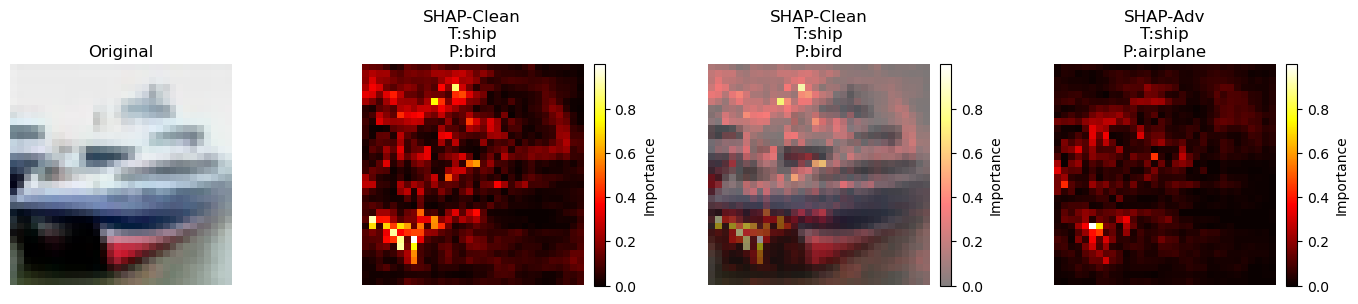

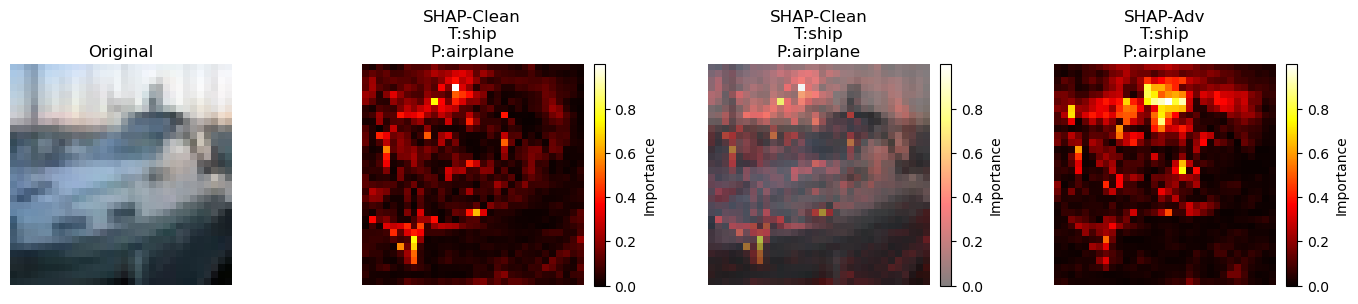

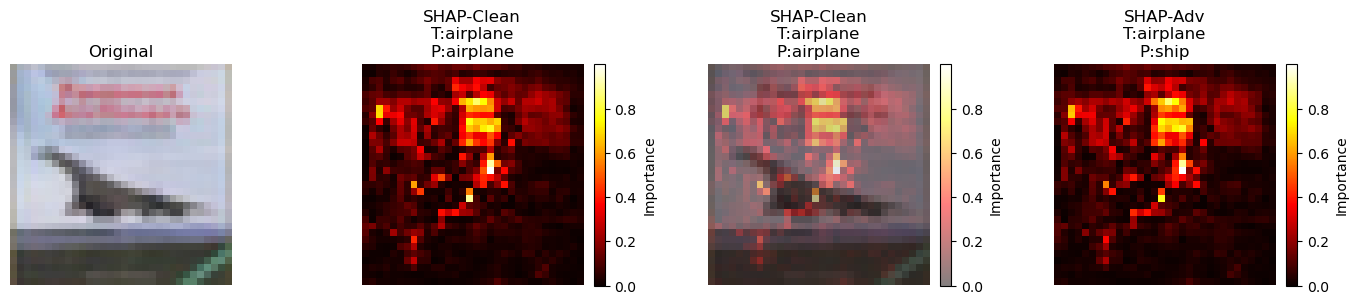

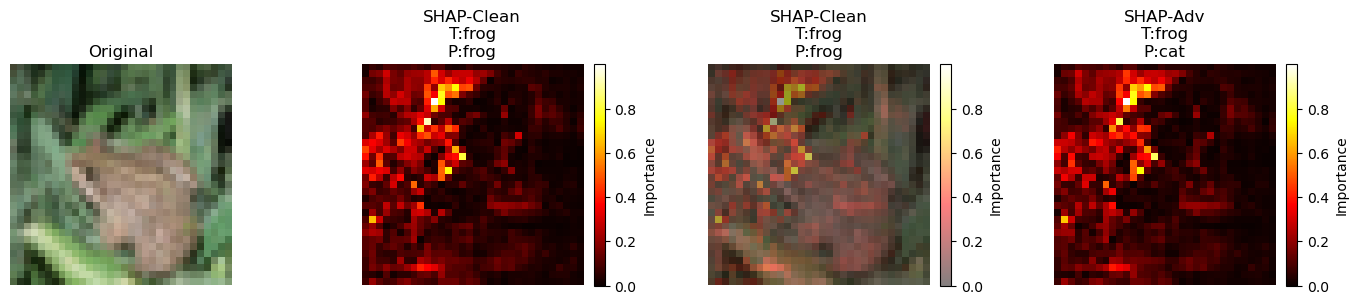

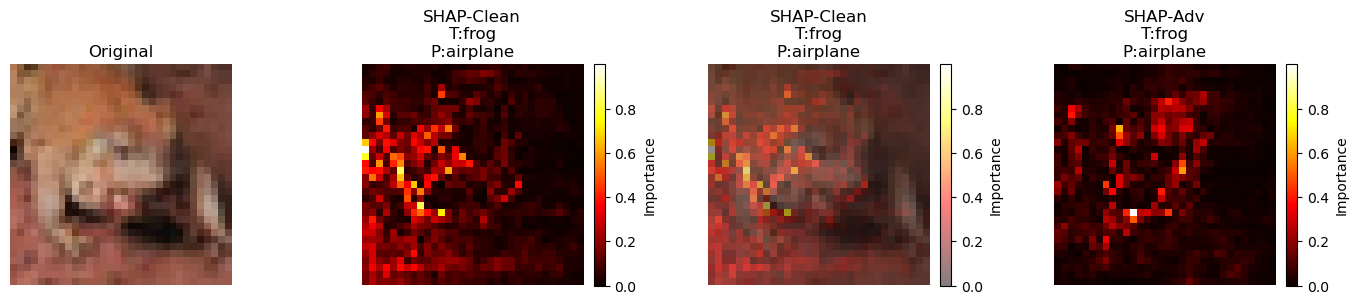

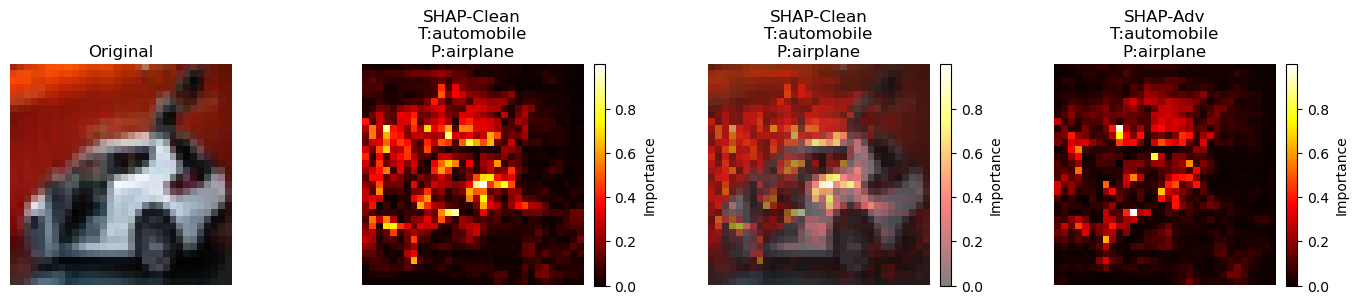

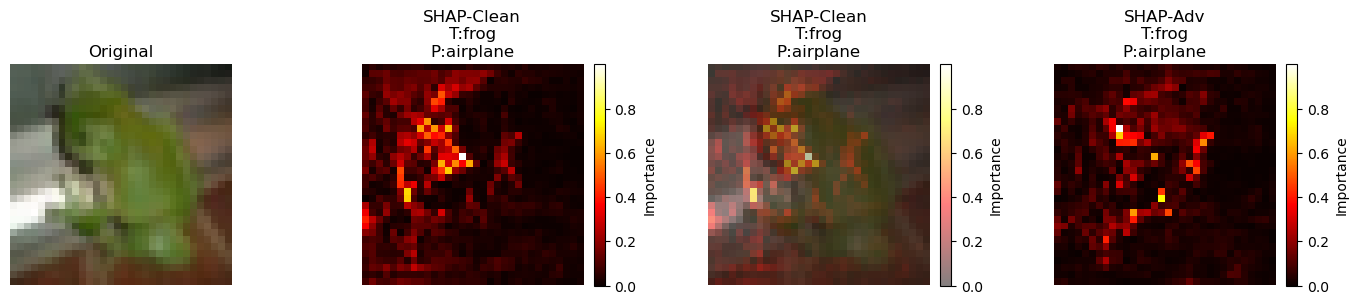

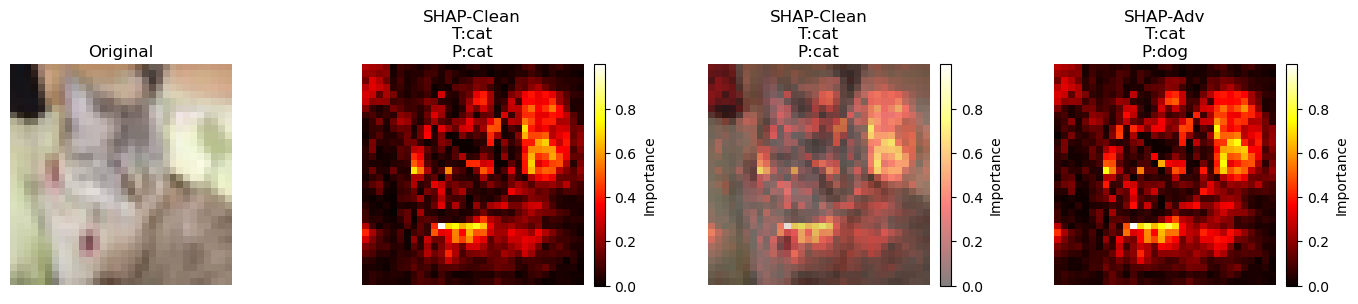

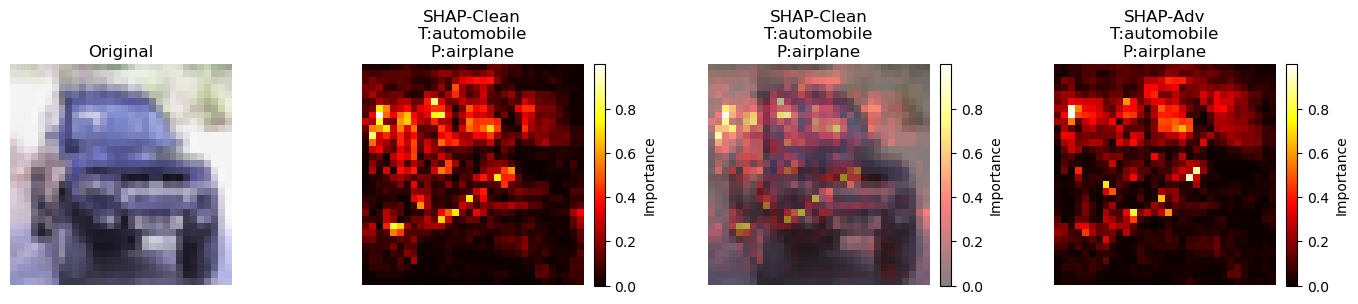

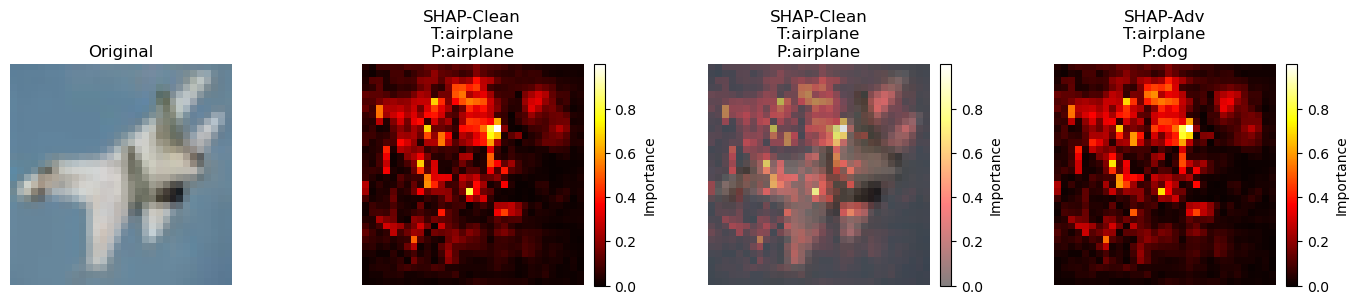

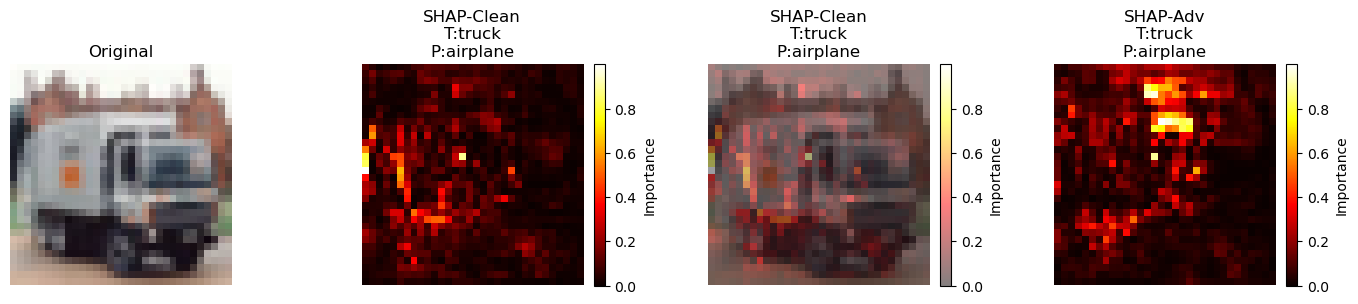

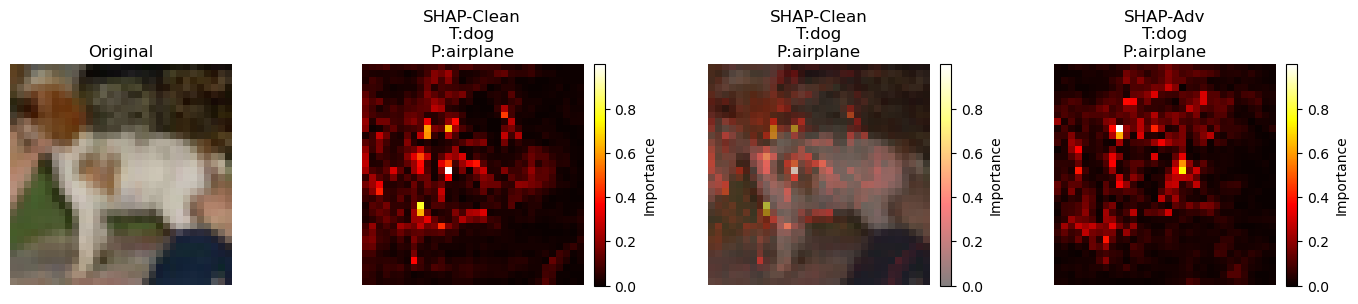

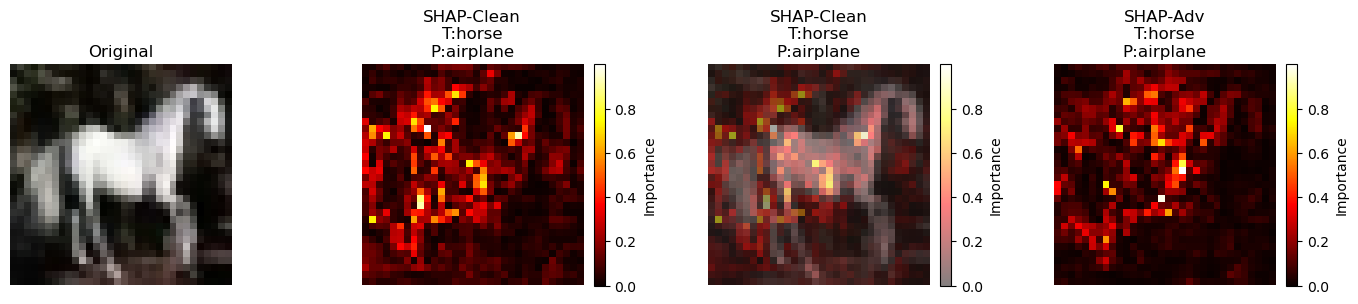

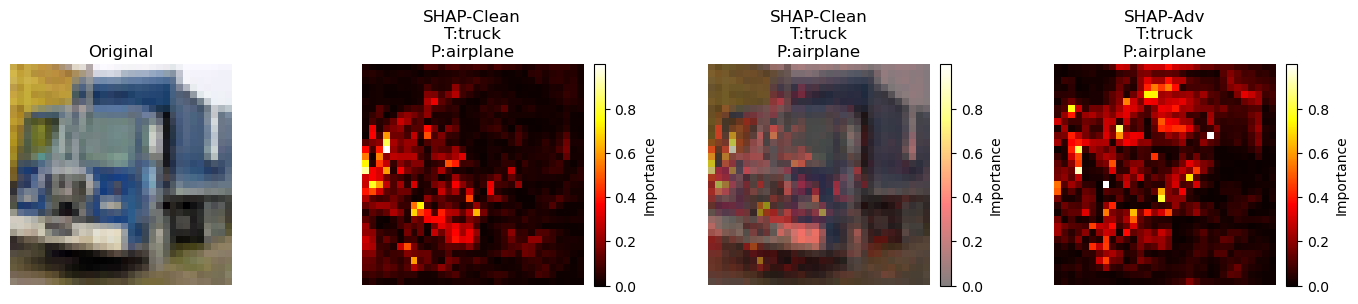

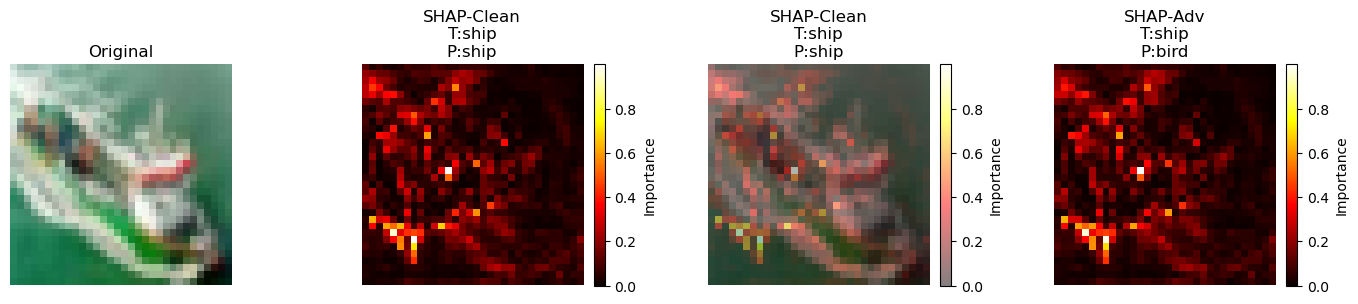

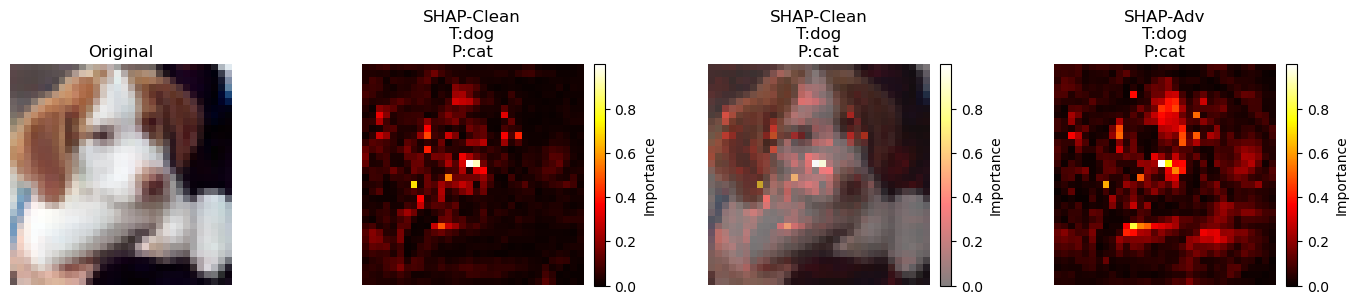

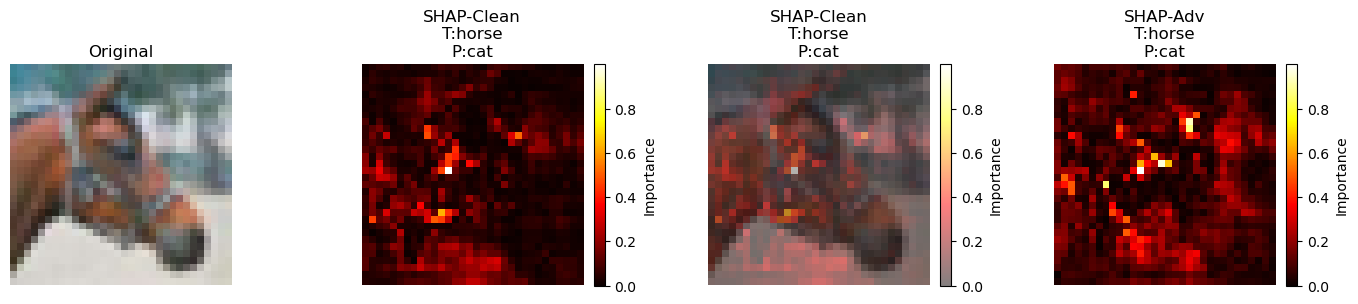

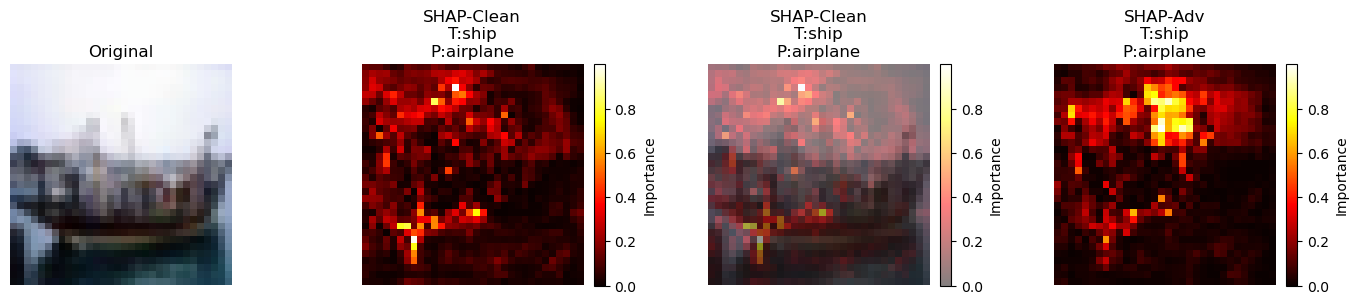

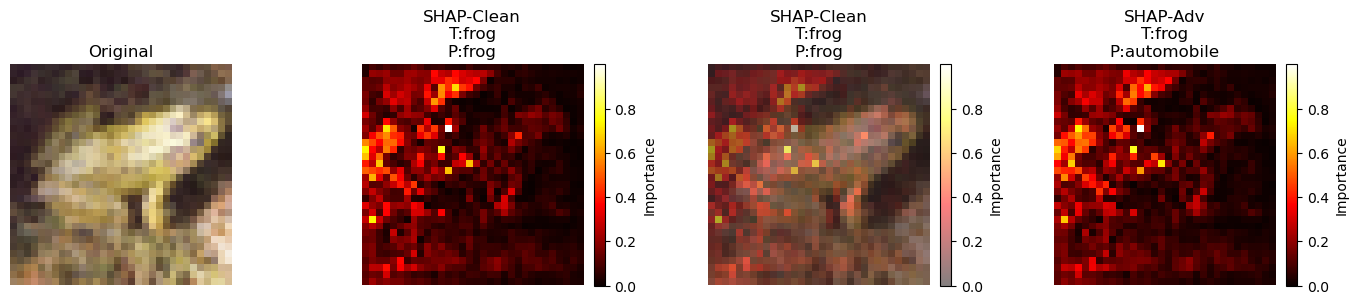

In [9]:
imgs_np  = images.detach().cpu().numpy()
adv_np   = adv_images.detach().cpu().numpy()
mean_arr = np.array(mean_list)
std_arr  = np.array(std_list)
classes  = testloader.dataset.classes
labels_c = labels.cpu()

for i in range(1,20):
    fig, axes = plt.subplots(1, 4, figsize=(14, 3))
    j = labels_c[i]
    k = preds_c[i]

    # Original image
    img = imgs_np[i].transpose(1, 2, 0) * std_arr + mean_arr
    img = np.clip(img, 0, 1)
    axes[0].imshow(img, cmap = 'gray')
    axes[0].set_title("Original")
    axes[0].axis('off')

    # SHAP heatmap (clean)
    heat_clean = np.abs(sh_vals_clean[j][i]).sum(axis=0)
    heat_clean_norm = (heat_clean - heat_clean.min()) / (heat_clean.max() - heat_clean.min() + 1e-8)
    # axes[1].imshow(img,cmap = 'gray', alpha=0.9)
    im_clean = axes[1].imshow(heat_clean_norm, cmap='hot', alpha=1)
    fig.colorbar(im_clean, ax=axes[1], fraction=0.046, pad=0.04, label="Importance")
    axes[1].set_title(f"SHAP-Clean\nT:{classes[labels_c[i]]}\nP:{classes[preds_c[i]]}")
    axes[1].axis('off')

    # Adversarial image
    heat_clean = np.abs(sh_vals_clean[j][i]).sum(axis=0)
    heat_clean_norm = (heat_clean - heat_clean.min()) / (heat_clean.max() - heat_clean.min() + 1e-8)
    axes[2].imshow(img,cmap = 'gray', alpha=0.9)
    im_clean = axes[2].imshow(heat_clean_norm, cmap='hot', alpha=0.5)
    fig.colorbar(im_clean, ax=axes[2], fraction=0.046, pad=0.04, label="Importance")
    axes[2].set_title(f"SHAP-Clean\nT:{classes[labels_c[i]]}\nP:{classes[preds_c[i]]}")
    axes[2].axis('off')


    # SHAP heatmap (adv)
    heat_adv = np.abs(sh_vals_adv[k][i]).sum(axis=0)
    heat_adv_norm = (heat_adv - heat_adv.min()) / (heat_adv.max() - heat_adv.min() + 1e-8)
    # axes[3].imshow(adv, cmap = 'gray', alpha=0.9)
    im_adv = axes[3].imshow(heat_adv_norm, cmap='hot', alpha=1)
    fig.colorbar(im_adv, ax=axes[3], fraction=0.046, pad=0.04, label="Importance")
    axes[3].set_title(f"SHAP-Adv\nT:{classes[labels_c[i]]}\nP:{classes[preds_a[i]]}")
    axes[3].axis('off')

    plt.tight_layout()
    plt.show()
